In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


2025-06-19 17:50:01.790171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750355402.002916      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750355402.064460      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def extract_emotion_features(filename, fixed_length=130):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    # MFCC + Delta
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc = librosa.util.fix_length(mfcc, size=fixed_length, axis=1)

    delta = librosa.feature.delta(mfcc)
    delta = librosa.util.fix_length(delta, size=fixed_length, axis=1)

    delta2 = librosa.feature.delta(mfcc, order=2)
    delta2 = librosa.util.fix_length(delta2, size=fixed_length, axis=1)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma = librosa.util.fix_length(chroma, size=fixed_length, axis=1)

    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = librosa.util.fix_length(contrast, size=fixed_length, axis=1)

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr = librosa.util.fix_length(zcr, size=fixed_length, axis=1)

    # Spectral Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    bandwidth = librosa.util.fix_length(bandwidth, size=fixed_length, axis=1)

    # Pitch using librosa's piptrack
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[magnitudes > np.median(magnitudes)]) if np.any(magnitudes > np.median(magnitudes)) else 0
    pitch_feature = np.full((1, fixed_length), pitch)

    # RMS energy
    rms = librosa.feature.rms(y=y)
    rms = librosa.util.fix_length(rms, size=fixed_length, axis=1)

    # Concatenate all features
    combined = np.concatenate((mfcc, delta,delta2, chroma, contrast, zcr, bandwidth, pitch_feature,rms), axis=0)

    return combined.T  # Shape: (time_steps, features)

In [3]:
def extract_label_from_filename(filename):
    emotion_code = int(filename.split('-')[2])
    emotion_map = {
        1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
        5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
    }
    return emotion_map.get(emotion_code)

# Load file paths and labels
file_paths = []
labels = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.wav'):
            label = extract_label_from_filename(filename)
            if label:
                path = os.path.join(dirname, filename)
                file_paths.append(path)
                labels.append(label)

df = pd.DataFrame({'audio': file_paths, 'label': labels})


In [4]:
X_features = [extract_emotion_features(f) for f in df['audio']]
X = np.array(X_features)
print(X.shape)

(2880, 130, 62)


In [5]:
def normalize_features(X):
    # Flatten to 2D
    num_samples, time_steps, num_features = X.shape
    X_flat = X.reshape(-1, num_features)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)
    joblib.dump(scaler, 'scaler.pkl')

    return X_scaled.reshape(num_samples, time_steps, num_features)

X = normalize_features(X)
print(X.shape)

(2880, 130, 62)


In [6]:


# Encode labels to integers
le = LabelEncoder()
y= le.fit_transform(df['label'])  # Integer labels for class_weight



# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
print(class_weights)
# One-hot encode for model training
y = to_categorical(y)
print(le.classes_)

{0: 0.9375, 1: 0.9375, 2: 0.9375, 3: 0.9375, 4: 0.9375, 5: 1.875, 6: 0.9375, 7: 0.9375}
['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='checkpoints/epoch_{epoch:02d}.weights.h5',
    save_weights_only=True,
    save_freq='epoch'
)
model = Sequential([
    
    
    Conv1D(64, 3, padding='same', activation='relu', input_shape=(X.shape[1], X.shape[2])),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=False)),
    BatchNormalization(),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32,callbacks=[checkpoint_cb])#,class_weight=class_weights)removed due to no improvement

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-19 17:53:59.090317: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.1577 - loss: 3.2561 - val_accuracy: 0.3247 - val_loss: 2.5059
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.3071 - loss: 2.5752 - val_accuracy: 0.3646 - val_loss: 2.2755
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.3891 - loss: 2.3111 - val_accuracy: 0.4635 - val_loss: 1.9653
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.4593 - loss: 2.0481 - val_accuracy: 0.5608 - val_loss: 1.8055
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.4991 - loss: 1.9367 - val_accuracy: 0.6007 - val_loss: 1.7053
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.6009 - loss: 1.6779 - val_accuracy: 0.6615 - val_loss: 1.5018
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.6401 - loss: 1.5571 - val_accuracy: 0.7031 - val_loss: 1.4396
Epoch 8/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.6838 - loss: 1.4619 - val_accuracy: 0

In [9]:
train_acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
loss=np.array(history.history['loss'])
val_loss=np.array(history.history['val_loss'])
avg_loss=(loss+val_loss)/2
avg_acc = (train_acc + val_acc) / 2
best_epoch = np.argmax(avg_acc) + 1  # +1 because epochs start from 1 in filenames

print(f"Best average (acc + val_acc)/2 at epoch {best_epoch},accuracy={train_acc[best_epoch-1]}, validation accuracy={val_acc[best_epoch-1]}, average value = {avg_acc[best_epoch-1]:.4f}")
history.model.load_weights(f"checkpoints/epoch_{best_epoch:02d}.weights.h5")
model.save("kaggle/working/model.h5")

Best average (acc + val_acc)/2 at epoch 185,accuracy=0.9913194179534912, validation accuracy=0.96875, average value = 0.9800


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

       angry       0.95      0.97      0.96        77
        calm       0.97      1.00      0.99        77
     disgust       1.00      0.95      0.97        77
     fearful       0.97      0.97      0.97        77
       happy       0.97      0.95      0.96        77
     neutral       0.95      0.95      0.95        38
         sad       0.95      0.97      0.96        77
   surprised       0.97      0.97      0.97        76

    accuracy                           0.97       576
   macro avg       0.97      0.97      0.97       576
weighted avg       0.97      0.97      0.97       576



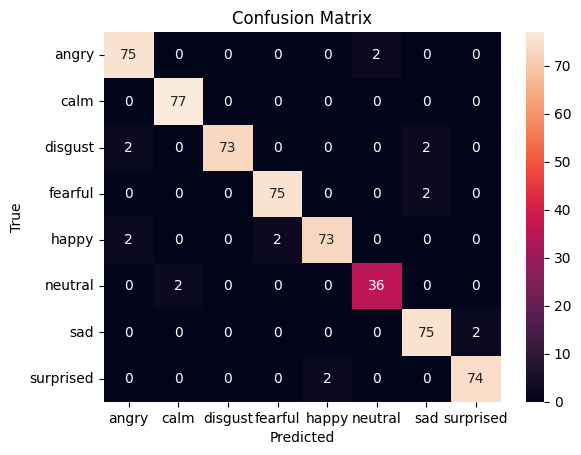

In [10]:
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
target_names = le.classes_


# Classification report
report =classification_report(y_true, y_pred_labels, target_names=target_names)
print(report)
with open("kaggle/working/classification_report.txt", "w") as f:
    f.write(report)
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("kaggle/working/confusion_matrix.png", dpi=300) 
plt.show()



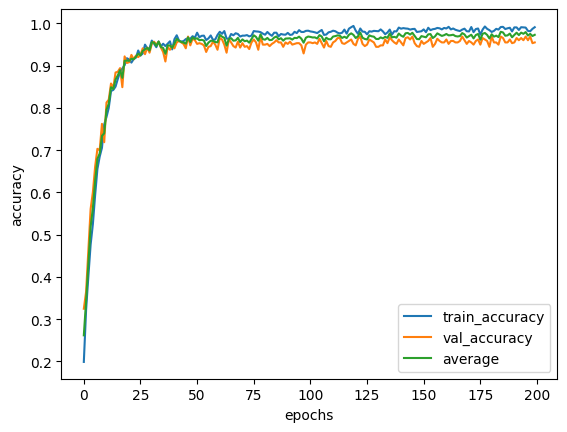

In [11]:


acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(len(acc))
plt.plot(epochs,acc,label='train_accuracy')
plt.plot(epochs,val_acc,label='val_accuracy')
plt.plot(epochs,avg_acc,label='average')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()



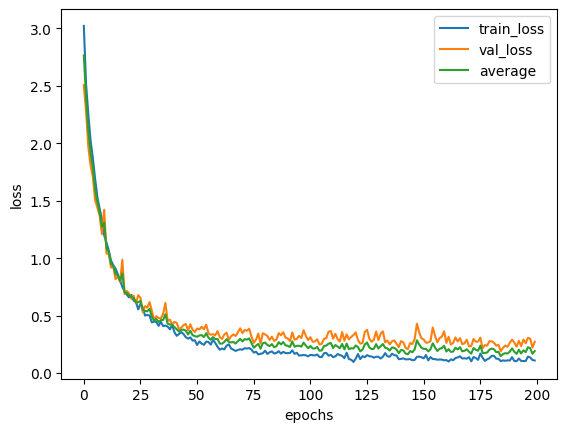

In [12]:


loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,loss,label='train_loss')
plt.plot(epochs,val_loss,label='val_loss')
plt.plot(epochs,avg_loss,label='average')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

